In [1]:
import torch
from torch.nn.functional import conv2d, softmax
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
def adjust_imgs(img_list, root_path, isInfrared, isReference=True, cut_area=0.75):
    """
    Processing images, padding reference images and cuting embeded images
    """
    imgs = []
    print("Loading dataset.")
    for img in img_list:
        img = cv2.imread(root_path+ "/" +img)
        print("Image shape: H:{}, W:{}, C:{}".format(img.shape[0], img.shape[1], img.shape[2]), end='\r')
        
        if isInfrared:
            img = img[:,:,1].reshape(img.shape[0], img.shape[1], 1)
            print("Infrared process: H:{}, W:{}, C:{}".format(img.shape[0], img.shape[1], img.shape[2]), end='\r')
            
        if isReference:
            img = np.pad(img, ((0,0), (int(img.shape[1]/2),int(img.shape[1]/2)), (0,0)), 'wrap')
            print("Reference imgs has padded, shape: {}".format(img.shape), end='\r')
            
        if not isReference:
            edge_L = int(img.shape[1]*(1-cut_area))
            edge_R = img.shape[1]
            img = img[:, edge_L:, :]
            emb_length = img.shape[1]
            print("Embeded imgs has cut, shape: {}".format(img.shape), end='\r')
            
        imgs.append(img)
    
    return imgs

In [3]:
def adjust_dataset(ref_data_file, emb_data_file, isInfrared):
    """
    Loading dataset and process whole dataset
    """
    ref_img_list = os.listdir(ref_data_file)
    emb_img_list = os.listdir(emb_data_file)
    
    used_imgs_number = 0
    
    if len(ref_img_list) <= len(emb_img_list):
        used_imgs_number = len(ref_img_list)
        emb_img_list = emb_img_list[:used_imgs_number]
        
    else:
        used_imgs_number = len(emb_img_list)
        ref_img_list = ref_img_list[:used_imgs_number] 
    
    ref_img_list = adjust_imgs(ref_img_list, ref_data_file, isInfrared)
    emb_img_list = adjust_imgs(emb_img_list, emb_data_file, isInfrared, isReference=False)
    
    print("{} reference images, {} embedded images, {} pair images used.".format(len(ref_img_list), len(emb_img_list), used_imgs_number, end = '/r')) 
    print("**********************************************************************************")
    
    return ref_img_list, emb_img_list

In [4]:
def correlate(reference_img, embed_img, origin_width, origin_height):
    
    reference_img_tensor = torch.from_numpy(reference_img.reshape(1,reference_img.shape[2],reference_img.shape[0],reference_img.shape[1]))
    embed_img_tensor = torch.from_numpy(embed_img.reshape(1,embed_img.shape[2],embed_img.shape[0],embed_img.shape[1]))
    
    match_map = conv2d(reference_img_tensor, embed_img_tensor)
    match_map= match_map.view(-1,1).float()
    
    mean = match_map.mean()
    std = match_map.std()
    
    likeli = (match_map-mean)/std
    likeli = softmax(match_map.view(-1,1).float(), dim = 0)
    likeli = likeli.numpy()
    
    displacement = np.arange(-int(origin_width/2), int(origin_width/2)+int(origin_width*0.25)+1)
    
    abs_error = abs(likeli.argmax() - 320 - origin_width*0.25)
    
    return likeli, displacement, abs_error

Loading dataset.
Loading dataset.as padded, shape: (480, 1280, 3)
1327 reference images, 1327 embedded images, 1327 pair images used.
**********************************************************************************
Loading dataset.
Loading dataset.as padded, shape: (480, 1280, 1)
1327 reference images, 1327 embedded images, 1327 pair images used.
**********************************************************************************
1327 pairs of RGB and IR images, RGB mean erros:289.86284853051995, IR mean errors:296.1469480030143, fusion mean errors:214.33006782215523
Loading dataset.
Loading dataset.as padded, shape: (480, 1280, 3)
1605 reference images, 1605 embedded images, 1605 pair images used.
**********************************************************************************
Loading dataset.
Loading dataset.as padded, shape: (480, 1280, 1)
1605 reference images, 1605 embedded images, 1605 pair images used.
***************************************************************************

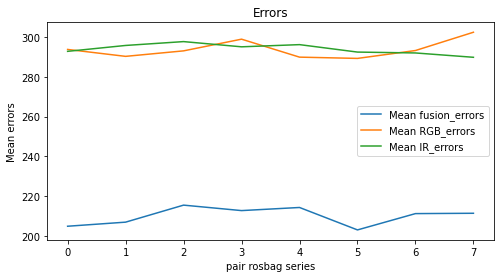

In [10]:
for i in range(1,3):
    root = "path" + str(i) + "/"
    
    for i in range(1,3):

        reference_file = root + str(i) + "/embeded/"
        reference_RGB_path = reference_file + "RGB"
        reference_IR_path = reference_file + "IR"

        embeded_file = root + str(i) + "/reference/"
        embeded_RGB_path = embeded_file + "RGB"
        embeded_IR_path = embeded_file + "IR"

        ref_RGB_list, emb_RGB_list = adjust_dataset(reference_RGB_path, embeded_RGB_path, isInfrared=False)
        ref_IR_list, emb_IR_list = adjust_dataset(reference_IR_path, embeded_IR_path, isInfrared=True)

        RGB_errors = []
        IR_errors = []
        fusion_errors = []
        number = 0

        for ref_RGB, emb_RGB, ref_IR, emb_IR in zip(ref_RGB_list, emb_RGB_list, ref_IR_list, emb_IR_list):

            number += 1
            print("Correlating images", end='\r')

            likeli_RGB, displacement, RGB_err = correlate(ref_RGB, emb_RGB, 640, 480)
            likeli_IR, displacement, IR_err = correlate(ref_IR, emb_IR, 640, 480)

            RGB_errors.append(RGB_err)
            IR_errors.append(IR_err)

            fusion_result =  likeli_RGB * likeli_IR
            fusion_err = abs(fusion_result.argmax() - 320 - 640*0.25)# As the array index from 0 not -320
            fusion_errors.append(fusion_err)

            print("Correlation finished, waiting for visulization.", end='\r')
            print("************", end='\r')

        fusion_errors = np.array(fusion_errors)
        RGB_errors = np.array(RGB_errors)
        IR_errors = np.array(IR_errors)

        print("{} pairs of RGB and IR images, RGB mean erros:{}, IR mean errors:{}, fusion mean errors:{}".format(number, RGB_errors.mean(), IR_errors.mean(), fusion_errors.mean()))
        path1_mError_fusion.append(fusion_errors.mean())
        path1_mError_RGB.append(RGB_errors.mean())
        path1_mError_IR.append(IR_errors.mean())

plt.figure("Mean errors", figsize = (8,4))
x_major_locator = plt.MultipleLocator(1)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.plot(path1_mError_fusion, label = 'Mean fusion_errors')
plt.plot(path1_mError_RGB, label = 'Mean RGB_errors')
plt.plot(path1_mError_IR, label = 'Mean IR_errors')
plt.title("Errors")
plt.xlabel("pair rosbag series")
plt.ylabel("Mean errors")
plt.legend()
plt.show()